# Section 4 프로젝트
### 1. 주제 : 미래에 상승할 종목을 맞추는 모델을 LSTM을 이용해서 만들어보자
### 2. 아이디어
- NLP에 사용된 개념을 주식에 대입해서 생각
    - 단어(word) -> 특정 '시점'의 종목 상태(재무상태, 주가 등)
    - 문장(sentence) -> 일정 '기간' 동안 종목이 어떤 일을 겪었는지 표현해주는 이야기
    - 모델(model)은 문장이 어떤 의미를 갖고 있는지 파악하고 원하는 task에 맞게 학습 -> 모델은 종목이 어떤 일을 겪었을 때 어떤 등락을 보이는지 학습
    - 예시
        - 삼성전자를 2013년 1월에 관찰(word1_1)하고, 2014년 1월에 관찰(word_2).. 그리고 2020년 1월(word_8)이라는 시점에 관찰해 각 시점의 관찰을 벡터화
        - 각 관찰을 시간 순으로 나열(sequence)하면 삼성전자가 2013~2020년의 기간 동안 겪은 이야기(sentence)가 됨.
        - 삼성전자, 현대차, 카카오.. 등의 이야기를 수집하여 각 이야기의 결과(상승 or 하락)는 어땠는지 학습  
        - 학습시키지 않은 종목의 이야기에 대해 예측 진행  
        => NLP의 감성분석(Sentiment analysis)과 유사한 문제


### 3. 목표 : 내가 고른 주식의 데이터를 넣었을 때, 해당 주식이 미래에 코스피 지수보다 더 오를지, 덜 오를지 '분류'하는 모델 만들기
- 모델 종류 : 이진 분류
- Target
    - 0 : 고른 종목(데이터)이 6개월 뒤 KOSPI보다 낮은 수익률을 보였다.
    - 1 : 고른 종목이 6개월 뒤 KOSPI보다 높은 수익률을 보였다.

### 4. 가설
- 주식 시장에 학습할 수 있는 규칙이 있으며, 이에 따라 미래 주가의 등락에 대해 어느 정도 예측이 가능하다.

### 5. Feature
- 특정 시점 주식의 상태
- 미래의 주가에 영향을 끼칠 것이라 예상되는 것들로 선정
- 종류
    1) 12개월 간 수익률 : 최근 12개월 간 수익률이 얼마나 났는가 (float)
    2) KOSPI대비 12개월 간 수익률 : 최근 12개월 간 KOSPI 대비 수익률이 얼마나 났는가 (float)
    3) 12개월 간 KOSPI 이김 : 최근 12개월 간 KOSPI 대비 수익률이 높았는가 (binary)
    4) PER_inv : 해당 종목, 해당 시점의 PER의 역수 (float)
    5) PBR_inv : 해당 종목, 해당 시점의 PBR의 역수 (float)
    6) 배당수익률 : 주주에게 배분된 배당금과 주주가 갖고 있는 주식 가치의 비 (float)

# 1. 데이터 수집
- 2013년 기준 시가총액 상위 1000 종목

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import FinanceDataReader as fdr
import warnings
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings(action='ignore')
%matplotlib inline
mpl.rc("font", family='Malgun Gothic')
plt.style.use('ggplot')
# pd.options.display.max_rows = 500

In [2]:
# 2013년부터 8년의 데이터

date_list = ['20130102', '20140102', '20150102', '20160102', '20170102', '20180102', '20190102', '20200102']

date_list_for_PER = date_list + ['20210102']

date_start = date_list[0]

N = 1000 # 시가총액 상위 N 종목

df = pd.read_csv('./data/{}_total_stock.csv'.format(date_start), encoding='euc-kr')

# 시가총액 상위 N종목의 종목코드 리스트
top_code = df.sort_values(by='시가총액', ascending=False).head(N).종목코드.to_list()

# 종목코드를 가지고 종목명을 찾을 수 있는 dictionary
code_to_name_dic = df[['종목코드', '종목명']].set_index('종목코드').to_dict()['종목명']

KOSPI = fdr.DataReader('KS11', date_start)

# 종목코드별 주가 데이터 dictionary에 저장
stock_price_dic = {}
for code in top_code:
    stock_price_dic[code] = fdr.DataReader(code, date_start)

# 2. 데이터 전처리 및 엔지니어링

In [3]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

print('date_add 함수 테스트 : {}'.format(date_add(date_start, 12)))


def earning_rate(stock_price : list, start_date, end_date) -> float:
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price
    
sample_stock_price = stock_price_dic[top_code[0]]

print('수익률 함수 테스트 : {:.4f}%'.format(earning_rate(sample_stock_price, '20170101', '20170603')*100))


def plot_stock(stock_price_dic : dict, code : str) -> None :
    '''stock_price_dic과 종목 code를 받으면 주가 변동을 그려주는 함수(종가 기준)'''
    plt.plot(stock_price_dic[code].Close)
    plt.xlabel('date')
    plt.ylabel('원')
    plt.title(code_to_name_dic[code])

date_add 함수 테스트 : 2014-01-03 00:00:00
수익률 함수 테스트 : 27.3130%


1위


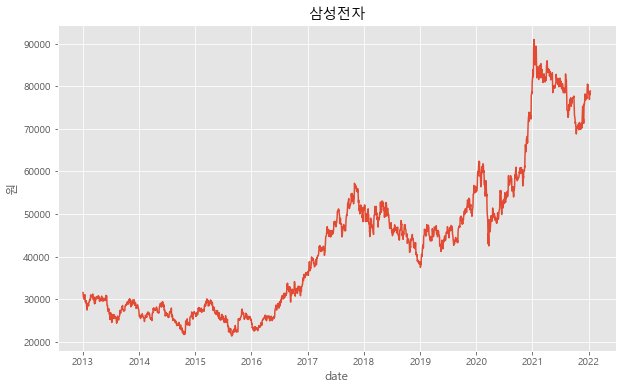

2위


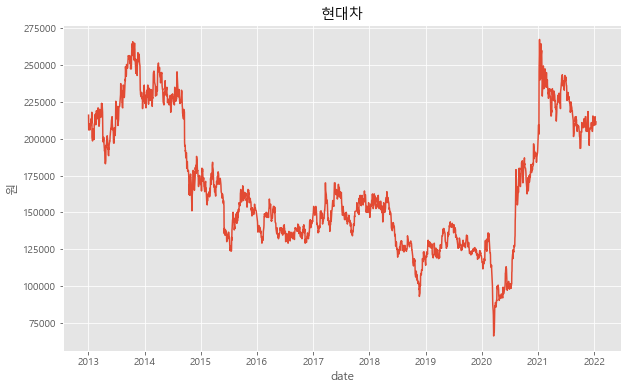

3위


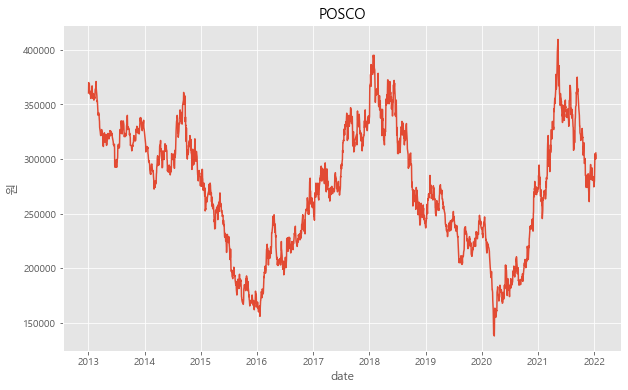

4위


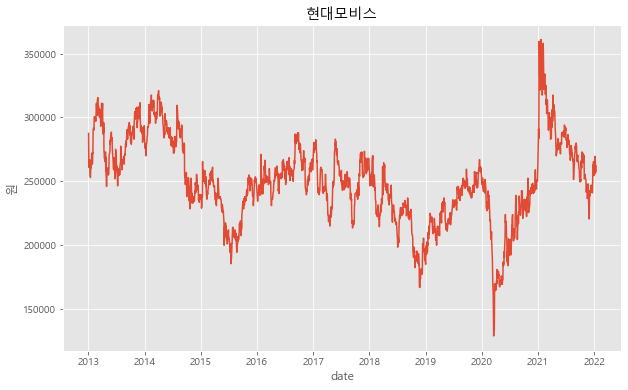

5위


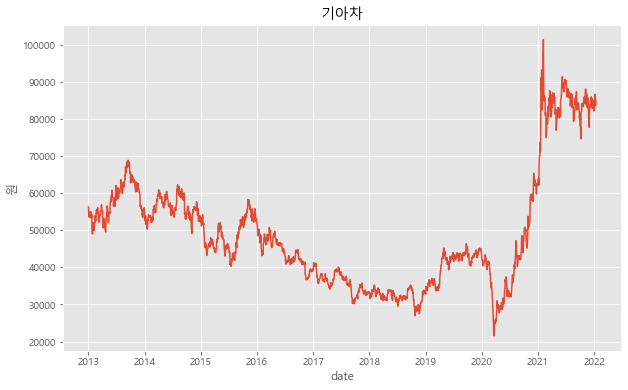

In [4]:
for i, code in enumerate(top_code[:5]):
    plt.figure(figsize=(10,6))
    plot_stock(stock_price_dic, code)
    print('{}위'.format(i+1))
    plt.show()

In [5]:
stock_price = stock_price_dic[top_code[0]]
stock_price.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2013-01-02,30660,31519,30540,31520,229274,0.035480
2013-01-03,31640,31680,30860,30860,284927,-0.020939
2013-01-04,30800,30840,30199,30500,260120,-0.011666
2013-01-07,30300,30560,29999,30400,252436,-0.003279
2013-01-08,30260,30340,29960,30000,276757,-0.013158


In [6]:
n = 12 # n개월 간의 주가 추이 확인
m = 6 # m개월 후의 수익률 확인

def ER_list_return(stock_price, n=n, m=m, date_list=date_list):
    '''stock_price정보를 가지고 base_date 기준 n개월 전, m개월 후 수익률(Earning Rate)을 구해준다.
    return : 데이터로 사용할 수익률, target을 구할 때 사용할 수익률, base_date'''
    earning_rate_list = []
    target_list = []
    base_date_list = []  # 수익률 기준일
    
    periods = 12//n # n = 2개월이면 12개월을 6개로 쪼개는 식
    for date in date_list:
        try:
            for period in range(periods): 
                date_start = date_add(date, period*n)
                date_end = date_add(date_start, n)
                
                ER_before = earning_rate(stock_price, date_start, date_end)
                ER_after = earning_rate(stock_price, date_end, date_add(date_end, m))
                
                earning_rate_list.append(ER_before)
                target_list.append(ER_after)
                base_date_list.append(date_end)
                
        except: # 종목코드가 바뀌거나 상장폐지돼서 주가 데이터가 없는 경우가 있는 것 같음. 이를 고려             
            break

    return earning_rate_list, target_list, base_date_list


# DataFrame 만들기 위해 모든 종목들에 대해 시행해주기
n_month_ER_data = []
m_month_ER_data = []
date_data = []
code_data = []

for code in top_code:
    stock_price = stock_price_dic[code]
    earning_rate_list, target_list, base_date_list = ER_list_return(stock_price)
    n_month_ER_data += earning_rate_list
    m_month_ER_data += target_list
    date_data += base_date_list
    code_data += [code]*len(base_date_list)

In [7]:
data = pd.DataFrame({
                     'date' : date_data,
                     'code' : code_data,
                     f'{n}개월 간 수익률': n_month_ER_data,
                     f'{m}개월 후 수익률' : m_month_ER_data
                    })

data['name'] = data.code.apply(lambda x: code_to_name_dic[x])

KOSPI_n_earning, KOSPI_m_earning, KOSPI_base_date = ER_list_return(KOSPI)

KOSPI_data = pd.DataFrame({
                     'date' : KOSPI_base_date,
                     f'KOSPI {n}개월 간 수익률': KOSPI_n_earning,
                     f'KOSPI {m}개월 후 수익률' : KOSPI_m_earning
                    })

data = data.merge(KOSPI_data, on='date')

# KOSPI 대비 수입률 Feature 만들기
data[f'KOSPI대비 {n}개월 간 수익률'] = data[f'{n}개월 간 수익률'] - data[f'KOSPI {n}개월 간 수익률']
data[f'KOSPI대비 {m}개월 후 수익률'] = data[f'{m}개월 후 수익률'] - data[f'KOSPI {m}개월 후 수익률']
data[f'{n}개월 간 KOSPI 이김'] = data[f'KOSPI대비 {n}개월 간 수익률'].apply(lambda x: 1 if x>=0 else 0)
data[f'KOSPI보다 많이 오름'] = data[f'KOSPI대비 {m}개월 후 수익률'].apply(lambda x: 1 if x>=0 else 0)



# PER 파일 불러와서 dic에 저장
df_PER_dic = {}
for date in date_list_for_PER:
    # 결측치는 0으로
    df_PER_dic[date] = pd.read_csv('./data/{}_PER_PBR.csv'.format(date), encoding='euc-kr')
    df_PER_dic[date][['PER', 'PBR']] = df_PER_dic[date][['PER', 'PBR']].fillna(10000)
    df_PER_dic[date][['배당수익률']] = df_PER_dic[date][['배당수익률']].fillna(0)

def near_date_for_PER(date, date_list=date_list_for_PER):
    '''한국거래소에서 받은 PER를 데이터 누수(미래의 PER 사용;) 없이 사용하기 위해 date에 따라 적절한 사용가능 날짜를 date_list에서 뽑아 리턴.
    date는 datetime 타입'''
    for d in date_list:
        d = datetime.strptime(d, '%Y%m%d')
        if d - timedelta(days=30) <= date < d + timedelta(days=336):
            return d.strftime('%Y%m%d')
    return date_list[0]

# near_date_for_PER(data.date[0])

def search_for_PER(code, date):
    '''code와 date 조건에 맞는 데이터를 PER가 담긴 df에서 찾아줌'''
    if type(date) != str:
        date = near_date_for_PER(date)
    df = df_PER_dic[date]
    cond = df['종목코드'] == code
    
    if cond.sum() == 0:
        fake_data = [0] * len(df.columns)
        return pd.DataFrame([fake_data], columns=df.columns)
    return df[cond]

# search_for_PER('069117', '20110102')

temp_df_list = []
for date, code in zip(data.date, data.code):
    temp_df_list.append(search_for_PER(code, date))
data_PER = pd.concat(temp_df_list, ignore_index=True)

data = pd.concat([ data, data_PER[['PER', 'PBR', '배당수익률']] ], axis=1)
data['PER_inv'] = 1/data['PER']
data['PBR_inv'] = 1/data['PBR']

data.head(3)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
0,2014-01-03,005930,-0.177665,0.007716,삼성전자,-0.04183,0.032639,-0.135835,-0.024923,0,0,8.50,1.90,0.61,0.117647,0.526316
1,2014-01-03,005380,0.037037,0.017857,현대차,-0.04183,0.032639,0.078867,-0.014782,1,0,7.12,1.46,0.85,0.140449,0.684932
2,2014-01-03,005490,-0.110957,-0.054602,POSCO,-0.04183,0.032639,-0.069127,-0.087241,0,0,10.10,0.71,2.48,0.099010,1.408451


In [8]:
data.shape

(7578, 16)

In [10]:
# nan 확인
data.isna().sum()

date                  0
code                  0
12개월 간 수익률            0
6개월 후 수익률             0
name                  0
KOSPI 12개월 간 수익률      0
KOSPI 6개월 후 수익률       0
KOSPI대비 12개월 간 수익률    0
KOSPI대비 6개월 후 수익률     0
12개월 간 KOSPI 이김       0
KOSPI보다 많이 오름         0
PER                   0
PBR                   0
배당수익률                 0
PER_inv               0
PBR_inv               0
dtype: int64

In [11]:
data.groupby('code').get_group('005930').shape

(8, 16)

In [12]:
X_list = [] # 각 종목코드별 데이터로 나눠주기
y_list = []

features = [f'{n}개월 간 수익률', f'KOSPI대비 {n}개월 간 수익률', f'{n}개월 간 KOSPI 이김', 'PER_inv', 'PBR_inv', '배당수익률']
target = ['KOSPI보다 많이 오름']

grouped_data = data.groupby('code')
for code in top_code:
    try:
        temp = grouped_data.get_group(code)
        
        # 중간에 데이터 수집이 되지 않은(상장폐지 or 미스터리한 이유..) 종목 제외. 이거 안해주면 list 크기가 다 달라서 np.array가 안 됨.
        if temp.shape[0] != len(date_list):
            print('다음 종목 코드는 데이터 수집이 되다 말았습니다. ->', code)
            continue
        X_list.append(temp[features].values.tolist()) # code란 종목코드의 feature 데이터를 리스트로 변환해 모아놓은 것
        y_list.append(temp[target].iloc[-1][0]) # code란 종목코드의 target을 리스트에 모아놓은 것
    except:
        print('다음 종목코드가 존재하지 않습니다. ->', code)

X = np.array(X_list)
y = np.array(y_list)

다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 000830
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 053000
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 003600
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 001300
다음 종목코드가 존재하지 않습니다. -> 004940
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 010520
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 003450
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 117930
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 037620
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 002550
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 033630
다음 종목코드가 존재하지 않습니다. -> 064420
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 130960
다음 종목코드가 존재하지 않습니다. -> 004010
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 068870
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 067250
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 003457
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 051310
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 016420
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 011160
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 021960
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 039530
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 004130
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 053320
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 016170
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 066270
다음 종목 코드는 데이터 수집이 되다 말았습니다. -> 00800

In [22]:
# 데이터 예시(삼성전자)
X[0]

array([[-0.17766497, -0.13583542,  0.        ,  0.11764706,  0.52631579,
         0.61      ],
       [ 0.01604278,  0.03675761,  1.        ,  0.14880952,  0.63694268,
         1.08      ],
       [-0.05263158, -0.07073232,  0.        ,  0.1270648 ,  0.79365079,
         1.66      ],
       [ 0.49792531,  0.44195166,  1.        ,  0.06997901,  0.56179775,
         1.16      ],
       [ 0.4299169 ,  0.20279268,  1.        ,  0.0619195 ,  0.45248869,
         1.12      ],
       [-0.2630341 , -0.06705887,  0.        ,  0.15479876,  0.72463768,
         2.19      ],
       [ 0.43225806,  0.34944214,  1.        ,  0.11709602,  0.64102564,
         2.57      ],
       [ 0.4673913 ,  0.14635893,  1.        ,  0.03813883,  0.45248869,
         1.71      ]])

In [23]:
y

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,

In [13]:
X.shape, y.shape

((909, 8, 6), (909,))

# 3. 모델링 및 예측

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train.shape, X_test.shape

((727, 8, 6), (182, 8, 6))

In [15]:
# basline model 정의
one_ratio = y_train.sum() / y.shape[0] # y에서 1(코스피보다 더 많이 오른 종목)의 비율
target_mode = 1 if one_ratio >= 0.5 else 0
baseline_model = [target_mode] * len(y_test) # precision check를 위해 baseline model은 1로
print('1의 비율 :', one_ratio)

1의 비율 : 0.5104510451045104


In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

def RNN():
    inputs = Input(name='inputs', shape=[X.shape[1], X.shape[2]])
    layer = LSTM(32)(inputs)
    layer = Dense(64, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

# model = tf.keras.models.Sequential([
# #   tf.keras.layers.Embedding(max_features, 128), # Embedding Layer를 거친 후의 shape : (batch_size, maxlen, embedding_size=128)
#   tf.keras.layers.LSTM(5, input_shape=(X_train.shape[1], X_train.shape[2])), # LSTM Layer를 거친 후의 shape : (batch_size, 1, hidden_size=128)
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])


model = RNN()
# model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=8, epochs=10, validation_split=0.2) #, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)])

Epoch 1/10
73/73 [==============================] - 2s 9ms/step - loss: nan - accuracy: 0.3787 - val_loss: nan - val_accuracy: 0.3699
Epoch 2/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 3/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 4/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 5/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 6/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 7/10
73/73 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.3597 - val_loss: nan - val_accuracy: 0.3699
Epoch 8/10
73/73 [==============================] - 0s 4ms/ste

In [ ]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3571


[nan, 0.3571428656578064]

In [ ]:
model.predict(X_test)

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

# 4. 결론
- 학습 실패..

# 5. 한계점
- 딥러닝과 LSTM에 대한 이해가 부족해 오류 발생 시 빠르게 대처할 수가 없었다.

- 중간에 상장폐지되는 종목은 고려되지 않았다.
- 기업들의 분기별 재무데이터를 DB화했다면 훨씬 다양한 작업들을 할 수 있었을 것이다.

In [27]:
# data.to_csv('stock_dataset.csv', encoding='euc-kr')